In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import umap
import matplotlib.patches as mpatches


def make_palette(n):
    return sns.color_palette("tab20", n) if n <= 20 else sns.color_palette("husl", n)

def legend_for_clusters(cluster_ids, palette):
    return [mpatches.Patch(color=palette[i % len(palette)], label=f"Cluster {cid}")
            for i, cid in enumerate(cluster_ids)]

def legend_for_classes(class_names, palette):
    return [mpatches.Patch(color=palette[i % len(palette)], label=name)
            for i, name in enumerate(class_names)]


def load_gse71585(expr_path, labels_path, label_column="broad_type"):
    expr = pd.read_csv(expr_path, compression='gzip', index_col=0)
    labels_df = pd.read_csv(labels_path, compression='gzip', index_col=0)
    print("Available label columns:", labels_df.columns.tolist())
    labels = labels_df.loc[expr.columns, label_column]
    return expr, labels, "GSE71585"


def run_pipeline(expr, labels, dataset_name, ablation=False):
    import time

    X = expr.T.astype(np.float32)
    X = X.loc[X.sum(axis=1) > 0]
    labels_aligned = labels.loc[X.index]

    # Normalize & log-transform
    X = X.div(X.sum(axis=1), axis=0) * 1e4
    X = X.fillna(0)
    X_log = np.log1p(X)
    X_log.columns = X_log.columns.astype(str)

    # PCA
    pca_dims = 20 if not ablation else 10
    X_pca = PCA(n_components=pca_dims, random_state=0).fit_transform(X_log)
    X2 = PCA(n_components=2, random_state=0).fit_transform(X_log)

    # UMAP embedding
    reducer = umap.UMAP(n_components=2, random_state=0, n_neighbors=15, min_dist=0.1)
    X_umap = reducer.fit_transform(X_log.values)

    le = LabelEncoder()
    true_labels_encoded = le.fit_transform(labels_aligned)

    results = {}
    metrics_records = []
    n_clusters = len(np.unique(labels_aligned))
    variant = "Ablation" if ablation else "Main"

    # ---------------------------
    # Hyperparameter sweeps
    # ---------------------------
    for linkage in ["ward", "average"]:
        key = f"Hierarchical_{linkage}"
        results[key] = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage).fit_predict(X_pca)

    for k in [n_clusters-2, n_clusters, n_clusters+2]:
        key = f"KMeans_k{k}"
        results[key] = KMeans(n_clusters=k, n_init=10, random_state=0).fit_predict(X_pca)

    for eps in [0.3, 0.5, 0.7]:
        key = f"DBSCAN_eps{eps}"
        results[key] = DBSCAN(eps=eps, min_samples=5).fit_predict(X_umap)

    adata = sc.AnnData(X_log)
    adata.var_names_make_unique()
    sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
    for res in [0.5, 1.0, 1.5]:
        sc.tl.leiden(adata, resolution=res, key_added=f"leiden_{res}",
                     flavor="igraph", n_iterations=2, directed=False)
        results[f"Leiden_res{res}"] = adata.obs[f"leiden_{res}"].astype(int).values

    # ---------------------------
    # Evaluation
    # ---------------------------
    for method, pred in results.items():
        ari = adjusted_rand_score(true_labels_encoded, pred)
        sil = silhouette_score(X_pca, pred) if len(np.unique(pred)) > 1 else np.nan
        metrics_records.append({
            "Variant": variant,
            "Method": method,
            "PCA_dims": pca_dims,
            "ARI": round(ari, 3),
            "Silhouette": round(sil, 3),
            "n_clusters_pred": len(np.unique(pred))
        })

    metrics_df = pd.DataFrame(metrics_records)
    print(f"\n=== Summary Table ({variant} run on {dataset_name}) ===")
    print(metrics_df.to_string(index=False))

    return metrics_df




expr, labels, name = load_gse71585(
    r"C:\Users\ibrah\OneDrive\Pictures\Bracu courses\CSE443\GSE71585_RefSeq_counts.csv.gz",
    r"C:\Users\ibrah\OneDrive\Pictures\Bracu courses\CSE443\GSE71585_Clustering_Results.csv.gz",
    label_column="broad_type"
)


# Collect results from both runs
df_main = run_pipeline(expr, labels, name, ablation=False)
df_ablation = run_pipeline(expr, labels, name, ablation=True)

# Combine into one table
df_all = pd.concat([df_main, df_ablation], ignore_index=True)
print("\n=== Combined Results (Main + Ablation) ===")
print(df_all.to_string(index=False))



Available label columns: ['mouse_line', 'cre_driver_1', 'cre_driver_2', 'cre_reporter', 'dissection', 'tdTomato', 'pass_qc_checks', 'broad_type', 'core_intermediate', 'primary_type', 'secondary_type', 'aibs_vignette_id']


c:\Users\ibrah\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



=== Summary Table (Main run on GSE71585) ===
Variant               Method  PCA_dims   ARI  Silhouette  n_clusters_pred
   Main    Hierarchical_ward        20 0.430       0.299                8
   Main Hierarchical_average        20 0.228       0.414                8
   Main            KMeans_k6        20 0.522       0.267                6
   Main            KMeans_k8        20 0.439       0.307                8
   Main           KMeans_k10        20 0.380       0.315               10
   Main        DBSCAN_eps0.3        20 0.221      -0.000               11
   Main        DBSCAN_eps0.5        20 0.147      -0.062                7
   Main        DBSCAN_eps0.7        20 0.083       0.478                3
   Main        Leiden_res0.5        20 0.433       0.109                8
   Main        Leiden_res1.0        20 0.467       0.232               11
   Main        Leiden_res1.5        20 0.337       0.262               13


c:\Users\ibrah\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



=== Summary Table (Ablation run on GSE71585) ===
 Variant               Method  PCA_dims   ARI  Silhouette  n_clusters_pred
Ablation    Hierarchical_ward        10 0.437       0.380                8
Ablation Hierarchical_average        10 0.229       0.396                8
Ablation            KMeans_k6        10 0.524       0.359                6
Ablation            KMeans_k8        10 0.443       0.403                8
Ablation           KMeans_k10        10 0.420       0.408               10
Ablation        DBSCAN_eps0.3        10 0.221      -0.048               11
Ablation        DBSCAN_eps0.5        10 0.147      -0.116                7
Ablation        DBSCAN_eps0.7        10 0.083       0.523                3
Ablation        Leiden_res0.5        10 0.433       0.081                8
Ablation        Leiden_res1.0        10 0.467       0.247               11
Ablation        Leiden_res1.5        10 0.337       0.285               13

=== Combined Results (Main + Ablation) ===
 Varia

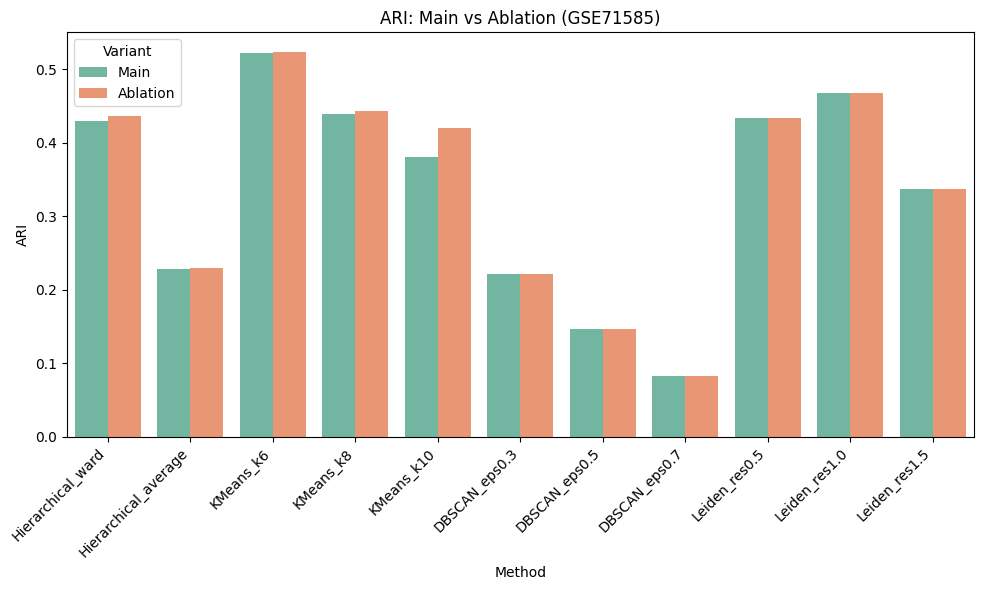

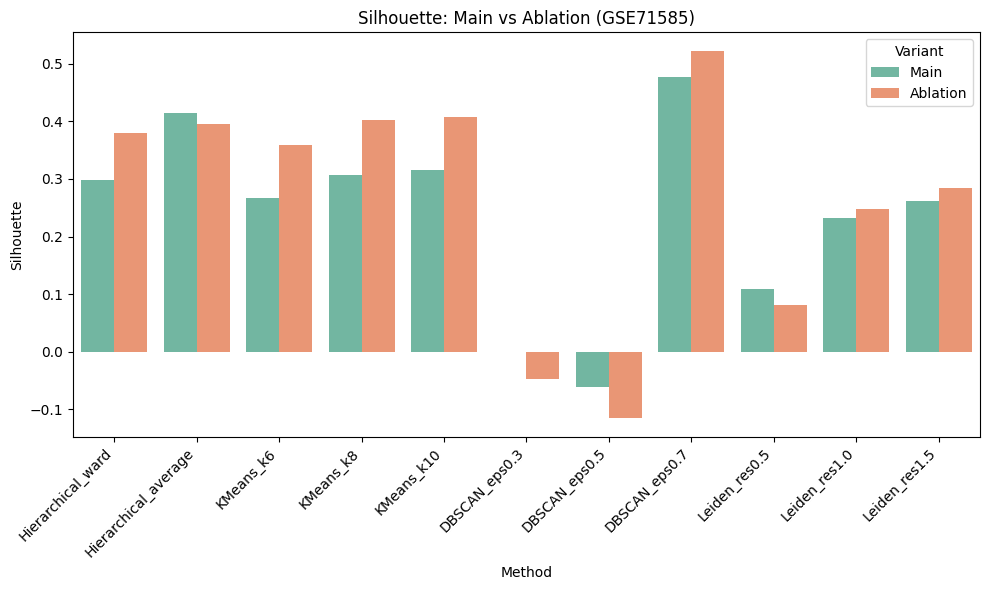

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure Variant is categorical with consistent order
df_all['Variant'] = pd.Categorical(df_all['Variant'], categories=['Main', 'Ablation'])

# ---------------------------
# 1. ARI comparison
# ---------------------------
plt.figure(figsize=(10,6))
sns.barplot(data=df_all, x="Method", y="ARI", hue="Variant", palette="Set2")
plt.title("ARI: Main vs Ablation (GSE71585)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("ablation_ari_bar.png", dpi=300)
plt.show()

# ---------------------------
# 2. Silhouette comparison
# ---------------------------
plt.figure(figsize=(10,6))
sns.barplot(data=df_all, x="Method", y="Silhouette", hue="Variant", palette="Set2")
plt.title("Silhouette: Main vs Ablation (GSE71585)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("ablation_silhouette_bar.png", dpi=300)
plt.show()
